In [1]:
import pandas as pd

df=pd.read_csv('d:/data/text/ratings_all.csv', encoding='ms949')
df.head()

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


0    100000
1    100000
Name: label, dtype: int64


<AxesSubplot:>

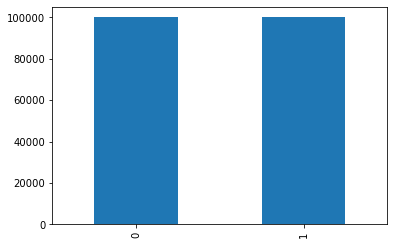

In [2]:
print(df['label'].value_counts()) # 긍정, 부정 비율 1:1
df['label'].value_counts().plot(kind='bar')

In [4]:
# 정규표현식
import re

text='I am a boy.#,:;!$!나는 1234 소년이다.'
re.sub('[^a-zA-Z ]', '', text) # 알파벳과 공백을 제외하고 모두 제거

'I am a boy  '

In [5]:
# 한글과 공백을 제외하고 모두 제거
df['document']=df['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
df[:5]

<ipython-input-5-8d4b8e86ae63>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['document']=df['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')


,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [6]:
import numpy as np
# 빈 문자열을 np.nan으로 바꾸고 inplace=True 기존 데이터프레임의 내용을 대체함
df['document'].replace('', np.nan, inplace=True)
print(df.isnull().sum()) # 결측값의 개수 확인(1116건)

document    1116
label          0
dtype: int64


In [7]:
df.loc[df.document.isnull()][:5] # 결측값 5개 확인

,document,label
584,NaN,0
593,NaN,0
638,NaN,0
668,NaN,0
1058,NaN,0


In [8]:
print(len(df))
df=df.dropna(how='any') # 결측값이 있는 행 제거
print(len(df))

200000
198884


In [9]:
X=df[['document']]
y=df['label']
print(X[:3])
print(y[:3])

                     document
0           아 더빙 진짜 짜증나네요 목소리
1  흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2           너무재밓었다그래서보는것을추천한다
0    0
1    1
2    0
Name: label, dtype: int64


In [10]:
from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample=RandomUnderSampler(random_state=0).fit_resample(X,y)

X_samp=pd.DataFrame(data=X_sample, columns=['document'])
y_samp=pd.DataFrame(data=y_sample, columns=['label'])
df_samp=pd.concat([X_samp,y_samp], axis=1)

In [11]:
df_samp['label'].value_counts()

0    99374
1    99374
Name: label, dtype: int64

In [12]:
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','한다'] # 불용어

In [13]:
from konlpy.tag import Okt

okt=Okt()
# 토큰화, stem 어근화
okt.morphs('아버지가 방에 들어가신다', stem=True)

['아버지', '가', '방', '에', '들어가다']

In [14]:
X=[]
y=[]
for idx, sentence in enumerate(df['document'][:30000]):
    temp=[]
    temp=okt.morphs(sentence, stem=True)
    temp=[word for word in temp if not word in stopwords] # 불용어가 아닌 단어들의 목록
    X.append(temp)
    y.append(df.iloc[idx,1]) # 0, 1 값을 리스트에 추가

In [15]:
print(X[:3])
print(y[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]
[0, 1, 0]


In [16]:
# 단어 집합을 만들고 단어에 고유한 숫자 인덱스를 부여
from keras.preprocessing.text import Tokenizer

tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)

In [18]:
i=0
for word in list(tokenizer.word_index.keys()):
    print(word,' → ',tokenizer.word_index[word])
    i+=1
    if i>5:
        break

영화  →  1
보다  →  2
하다  →  3
을  →  4
없다  →  5
이다  →  6


In [22]:
threshold=3
total_cnt=len(tokenizer.word_index) # 단어의 수
rare_cnt=0 # 출현 빈도수가 threshold보다 작은 단어의 개수
total_freq=0 # X 데이터의 전체 단어 빈도수 총합
rare_freq=0 # 출현 빈도수가 threshold보다 작은 단어의 출현 빈도의 총합

# 단어와 빈도수의 pair
for key, value in tokenizer.word_counts.items():
    total_freq+=value
    if value < threshold: # 단어의 출현빈도수가 threshold보다 작으면
        rare_cnt+=1
        rare_freq+=value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('출현 빈도가 %s번 이하인 희귀 단어의 수 : %s' % (threshold-1, rare_cnt))
print(f'단어 집합에서 희귀 단어의 비율 : {(rare_cnt/total_cnt)*100:.2f}%')

단어 집합(vocabulary)의 크기 : 21085
출현 빈도가 2번 이하인 희귀 단어의 수 : 12823
단어 집합에서 희귀 단어의 비율 : 60.82%


In [23]:
vocab_size=total_cnt-rare_cnt+1 # 전체 단어 개수 중 빈도수 2이하인 희귀 단어 제거
print(f'단어 집합의 크기 : {vocab_size}')

단어 집합의 크기 : 8263


In [24]:
tokenizer=Tokenizer(vocab_size) # 상위 단어 개수 지정
tokenizer.fit_on_texts(X)

i=0
for word in list(tokenizer.word_index.keys()):
    print(word, ' → ', tokenizer.word_index[word])
    i+=1
    if i>5:
        break

영화  →  1
보다  →  2
하다  →  3
을  →  4
없다  →  5
이다  →  6


In [25]:
# 텍스트를 시퀀스로 변환
X2=tokenizer.texts_to_sequences(X) # 단어의 인덱스로만 구성된 새로운 리스트
print(X[:3])
print(X2[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]
[[52, 477, 17, 251, 668], [934, 419, 42, 640, 1, 180, 1576, 25, 1000, 714, 19], [360, 2049, 2720, 3614, 2, 220, 10]]


In [26]:
for index, sentence in enumerate(X2[:10]):
    print(index,sentence)

0 [52, 477, 17, 251, 668]
1 [934, 419, 42, 640, 1, 180, 1576, 25, 1000, 714, 19]
2 [360, 2049, 2720, 3614, 2, 220, 10]
3 [6593, 114, 223, 50, 5, 24, 3615]
4 [1001, 33, 6594, 25, 753, 1, 1771, 22, 1267, 266, 3, 1133, 224, 266]
5 [766, 4875, 979, 1349, 464, 133, 1772, 1843, 5545, 247, 1, 89, 122, 947, 45, 260]
6 [225, 312, 4, 330, 593, 3]
7 [122, 947, 45, 313, 27, 306, 112, 1968, 349, 116, 227, 11, 651, 18, 630, 585, 415, 504, 3616, 13, 1247, 1247, 37, 302, 5, 25, 36, 3, 40, 13, 728, 1077, 68]
8 [90, 5, 50, 7, 349, 102, 1]
9 [1422, 24, 197, 564, 81, 13, 367, 1295, 375, 600, 9, 6595, 7]


In [27]:
# 단어가 하나도 없는 문장들을 제거하기 위한 리스트
drop_X=[index for index, sentence in enumerate(X2) if len(sentence)<1]
drop_X[:10]

[28, 169, 404, 412, 416, 470, 549, 1153, 1307, 1353]

In [28]:
# 단어가 하나도 없는 문장들을 제거
X_text=np.delete(X, drop_X, axis=0)
X=np.delete(X2, drop_X, axis=0)
y=np.delete(y, drop_X, axis=0)
print(X.shape)
print(y.shape)

(29837,)
(29837,)


D:\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 63
리뷰의 평균 길이 : 10.65552837081476


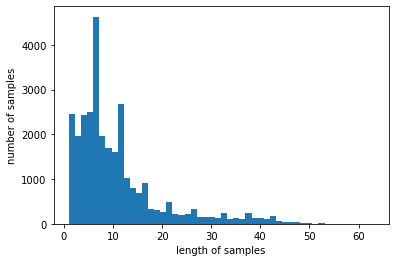

In [29]:
import matplotlib.pyplot as plt
max_len=max(len(l) for l in X)
print('리뷰의 최대 길이 :',max_len)
print('리뷰의 평균 길이 :',sum(map(len,X))/len(X))
plt.hist([len(s) for s in X], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
from keras.preprocessing.sequence import pad_sequences
# 최대 사이즈에 맞춰 빈칸에 0으로 채움
X=pad_sequences(X, maxlen=max_len)
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  52, 477,  17, 251, 668])

In [31]:
print(X.shape)
print(y.shape)

(29837, 63)
(29837,)


In [32]:
# 학습용, 검증요 8:2로 구분
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23869, 63)
(5968, 63)
(23869,)
(5968,)


In [34]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential

model=Sequential()
model.add(Embedding(vocab_size, 100)) # Embedding(입력 사이즈, 출력 사이즈)
# 문장을 단어들의 시퀀스로 간주하고 순환 레이어의 입력으로, 출력 노드수 128로 설정
model.add(LSTM(128)) # Long Short-Term Memory
model.add(Dense(1, activation='sigmoid', name='output'))  # 출력층
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
hist=model.fit(X_train, y_train, epochs=15, batch_size=60, validation_split=0.2)

Epoch 1/15
319/319 [==============================] - 16s 19ms/step - loss: 0.4789 - accuracy: 0.7761 - val_loss: 0.3998 - val_accuracy: 0.8121
Epoch 2/15
319/319 [==============================] - 5s 17ms/step - loss: 0.3558 - accuracy: 0.8459 - val_loss: 0.3818 - val_accuracy: 0.8188
Epoch 3/15
319/319 [==============================] - 5s 17ms/step - loss: 0.3130 - accuracy: 0.8690 - val_loss: 0.3783 - val_accuracy: 0.8243
Epoch 4/15
319/319 [==============================] - 5s 17ms/step - loss: 0.2949 - accuracy: 0.8787 - val_loss: 0.3911 - val_accuracy: 0.8217
Epoch 5/15
319/319 [==============================] - 5s 17ms/step - loss: 0.2769 - accuracy: 0.8865 - val_loss: 0.3850 - val_accuracy: 0.8255
Epoch 6/15
319/319 [==============================] - 5s 17ms/step - loss: 0.2616 - accuracy: 0.8939 - val_loss: 0.3792 - val_accuracy: 0.8280
Epoch 7/15
319/319 [==============================] - 5s 17ms/step - loss: 0.2446 - accuracy: 0.9001 - val_loss: 0.4322 - val_accuracy: 0.820

In [36]:
scores=model.evaluate(X_test, y_test[:X_test.shape[0]], verbose=0)
print(scores)

[0.5977094173431396, 0.8068029284477234]


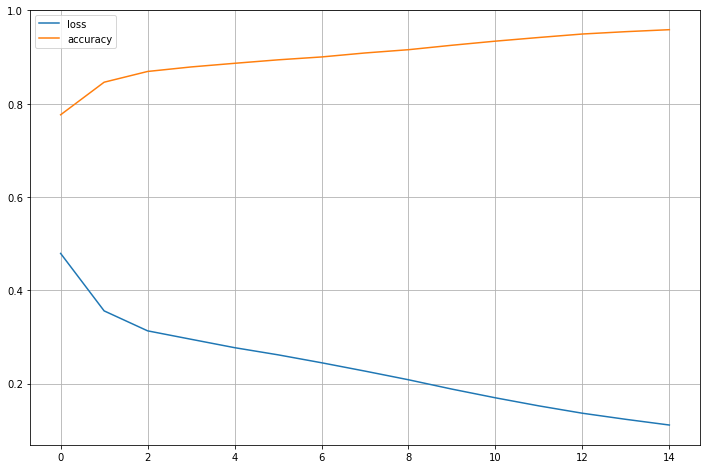

In [37]:
# 모델 학습 과정 표시
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss']) # 손실
plt.plot(hist.history['accuracy']) # 정확도
plt.legend(['loss','accuracy'])
plt.grid()
plt.show()